In [2]:
import os 
import json

BASE_OUTPUT_DIR="/mnt/task_runtime/results"

models = [
    "Qwen3-VL-2B-GRPO-MRI-600-think",
    "Qwen3-VL-2B-KDPO-MRI-600-think-tau-0",
    "Qwen3-VL-2B-KDPO-MRI-600-think-tau-0-235b-a22b",
    "Qwen3-VL-2B-KDPO-MRI-600-think-tau-1",
    
]

CHECKPOINTS_STEP = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190
]

CHECKPOINTS_NAME = [f"checkpoint-{step}" for step in CHECKPOINTS_STEP]

MODALITIES = ["CT", "Dermoscopy", "Fundus", "MRI", "Microscopy", "OCT", "Ultrasound", "XRay"]
METRICS = ["accuracy"]

def collect_results(model, checkpoint_name, modality, metrics=METRICS):
    model_path = os.path.join(BASE_OUTPUT_DIR, "_".join([model, checkpoint_name]))
    # find the json in which it contains the modality
    full_file_path = None
    for file in os.listdir(model_path):
        # skip non-JSON files (e.g., editor swap/temp files)
        if not file.endswith(".json"):
            continue
        if "test_" + modality in file:
            full_file_path = os.path.join(model_path, file)
            break

    if full_file_path is None:
        return {}
    # read the json file
    with open(full_file_path, "r") as f:
        data = json.load(f)

    # get the metrics
    metrics_data = {}
    for metric in metrics:
        metrics_data[metric] = data[metric]

    print(f"model_path: {model_path}", f"modality: {modality}", f"metrics: {metrics}", f"full_file_path: {full_file_path}", f"metrics_data: {metrics_data}")
    
    
    return metrics_data

def collect_all_results(model, checkpoint_name, modalities=MODALITIES, metrics=METRICS):
    all_results = {}
    for modality in modalities:
        results = collect_results(model, checkpoint_name, modality, metrics)
        all_results[modality] = results
    return all_results

def collect_all_results_for_all_checkpoints(model, checkpoints_name=CHECKPOINTS_NAME, modalities=MODALITIES, metrics=METRICS):
    all_results = {}
    for checkpoint_name in checkpoints_name:
        results = collect_all_results(model, checkpoint_name, modalities, metrics)
        all_results[checkpoint_name] = results
    return all_results

def collect_all_results_for_all_models(models=models, checkpoints_name=CHECKPOINTS_NAME, modalities=MODALITIES, metrics=METRICS):
    all_results = {}
    for model in models:
        results = collect_all_results_for_all_checkpoints(model, checkpoints_name, modalities, metrics)
        all_results[model] = results
    return all_results

results = collect_all_results_for_all_models(models)
print(json.dumps(results, indent=4))

model_path: /mnt/task_runtime/results/Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10 modality: CT metrics: ['accuracy'] full_file_path: /mnt/task_runtime/results/Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10/test_CT_Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10_results.json metrics_data: {'accuracy': 45.0}
model_path: /mnt/task_runtime/results/Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10 modality: Dermoscopy metrics: ['accuracy'] full_file_path: /mnt/task_runtime/results/Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10/test_Dermoscopy_Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10_results.json metrics_data: {'accuracy': 69.0}
model_path: /mnt/task_runtime/results/Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10 modality: Fundus metrics: ['accuracy'] full_file_path: /mnt/task_runtime/results/Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10/test_Fundus_Qwen3-VL-2B-GRPO-MRI-600-think_checkpoint-10_results.json metrics_data: {'accuracy': 74.33333333333333}
model_path: /mnt/task_runtime/results/Qwen3-VL-2B-G

In [3]:
print(results.keys())
print(results["Qwen3-VL-2B-GRPO-MRI-600-think"].keys())
print(results["Qwen3-VL-2B-GRPO-MRI-600-think"]["checkpoint-10"].keys())
print(results["Qwen3-VL-2B-GRPO-MRI-600-think"]["checkpoint-10"]["MRI"])

dict_keys(['Qwen3-VL-2B-GRPO-MRI-600-think', 'Qwen3-VL-2B-KDPO-MRI-600-think-tau-0', 'Qwen3-VL-2B-KDPO-MRI-600-think-tau-0-235b-a22b', 'Qwen3-VL-2B-KDPO-MRI-600-think-tau-1'])
dict_keys(['checkpoint-10', 'checkpoint-20', 'checkpoint-30', 'checkpoint-40', 'checkpoint-50', 'checkpoint-60', 'checkpoint-70', 'checkpoint-80', 'checkpoint-90', 'checkpoint-100', 'checkpoint-110', 'checkpoint-120', 'checkpoint-130', 'checkpoint-140', 'checkpoint-150', 'checkpoint-160', 'checkpoint-170', 'checkpoint-180', 'checkpoint-190'])
dict_keys(['CT', 'Dermoscopy', 'Fundus', 'MRI', 'Microscopy', 'OCT', 'Ultrasound', 'XRay'])
{'accuracy': 61.33333333333333}


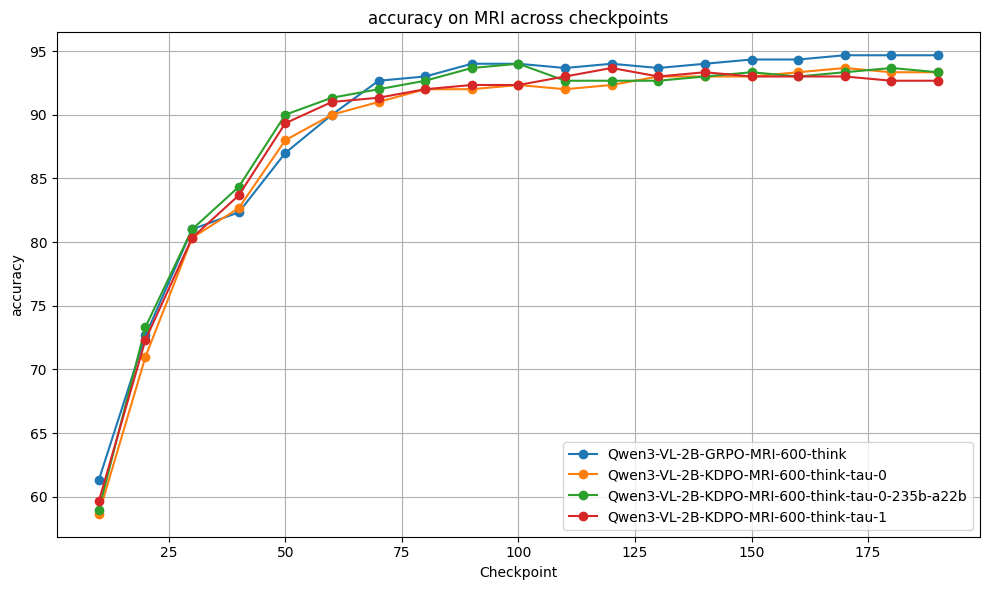

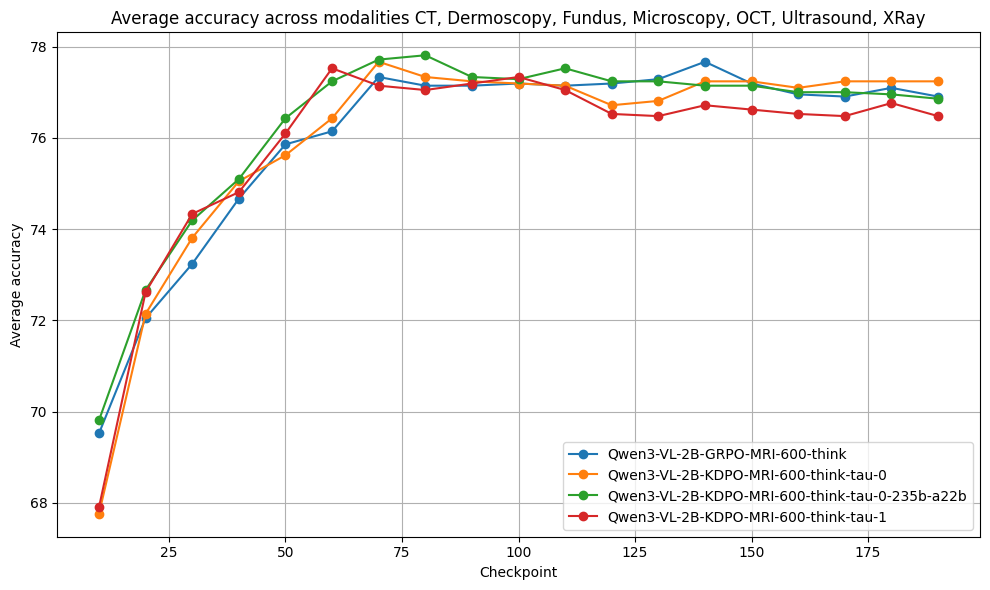

In [4]:
import matplotlib.pyplot as plt

def plot_metric_across_checkpoints(results, modality, metric, models=models, checkpoints_name=CHECKPOINTS_NAME):
    """
    Plots the value of a given metric for a specific modality across all checkpoints, for all models.
    
    Args:
        results (dict): Results dict with format explained above.
        modality (str): The modality to plot, e.g. "Fundus".
        metric (str): The metric to plot, e.g. "accuracy".
        models (list): List of model names.
        checkpoints_name (list): List of checkpoint names (str or int).
    """
    plt.figure(figsize=(10, 6))
    
    for model in models:
        x = []
        y = []
        for checkpoint in checkpoints_name:
            x.append(str(checkpoint))
            metric_value = None
            try:
                metric_value = results[model][checkpoint][modality][metric]
            except Exception:
                metric_value = None
            # Convert metric_value to float if possible, else np.nan
            try:
                metric_value = float(metric_value)
            except:
                metric_value = float('nan')
            y.append(metric_value)
        plt.plot(CHECKPOINTS_STEP, y, marker='o', label=model)
    
    plt.title(f"{metric} on {modality} across checkpoints")
    plt.xlabel("Checkpoint")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metric_across_checkpoints(results, modality='MRI', metric='accuracy')

# provide a function to plot the average of one specific metric across selected modalities for all models
def plot_average_metric_across_modalities(results, metric, modalities=MODALITIES, checkpoints_name=CHECKPOINTS_NAME):
    """
    Plots the average value of a given metric across selected modalities for all models.
    
    Args:
        results (dict): Results dict with format explained above.
        metric (str): The metric to plot, e.g. "accuracy".
        modalities (list): List of modalities to plot.
    """
    plt.figure(figsize=(10, 6))
    for model in models:
        avg_metric_per_checkpoint = []
        for checkpoint in checkpoints_name:
            metric_sum = 0
            metric_cnt = 0
            for modality in modalities:
                try:
                    value = results[model][checkpoint][modality][metric]
                    value = float(value)
                    metric_sum += value
                    metric_cnt += 1
                except Exception:
                    continue
            avg = metric_sum / metric_cnt if metric_cnt > 0 else float('nan')
            avg_metric_per_checkpoint.append(avg)
        plt.plot(CHECKPOINTS_STEP, avg_metric_per_checkpoint, marker='o', label=model)
    
    plt.title(f"Average {metric} across modalities {', '.join(modalities)}")
    plt.xlabel("Checkpoint")
    plt.ylabel(f"Average {metric}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

index_of_mri = MODALITIES.index("MRI")
modailities_without_mri = MODALITIES[:index_of_mri] + MODALITIES[index_of_mri+1:]

plot_average_metric_across_modalities(results, modalities=modailities_without_mri, metric='accuracy')

In [5]:
MODALITIES

['CT',
 'Dermoscopy',
 'Fundus',
 'MRI',
 'Microscopy',
 'OCT',
 'Ultrasound',
 'XRay']

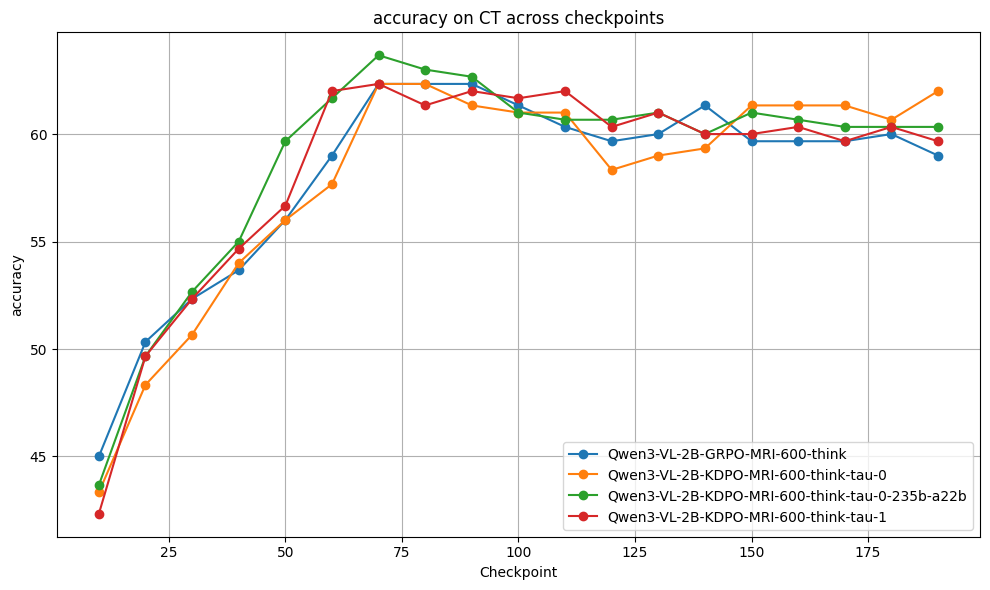

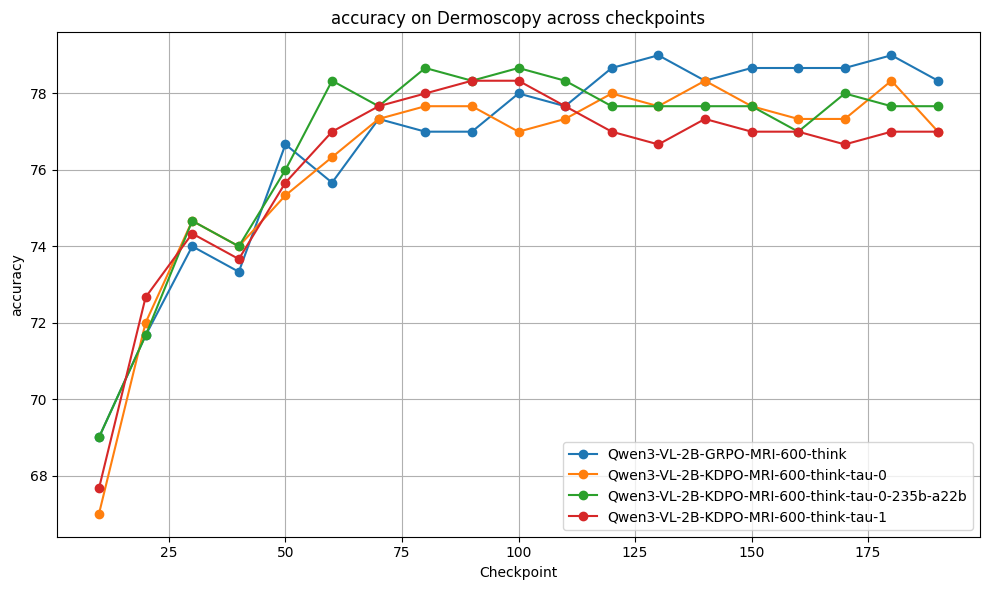

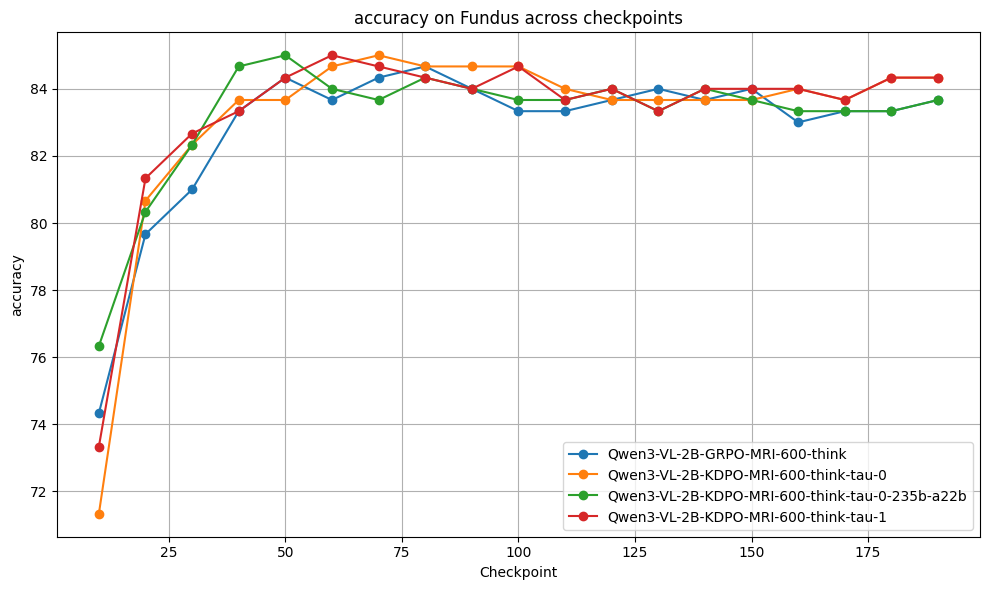

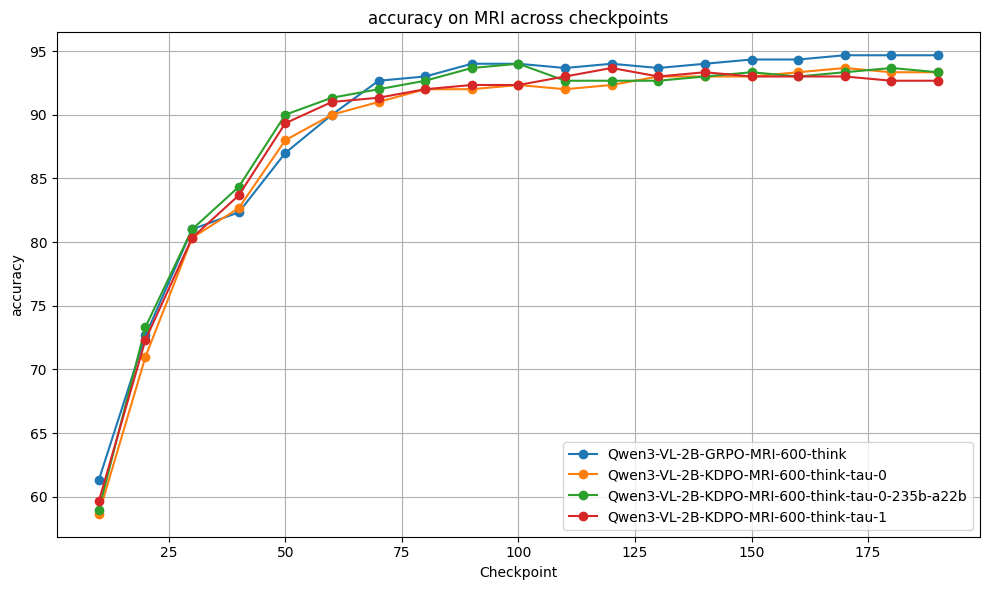

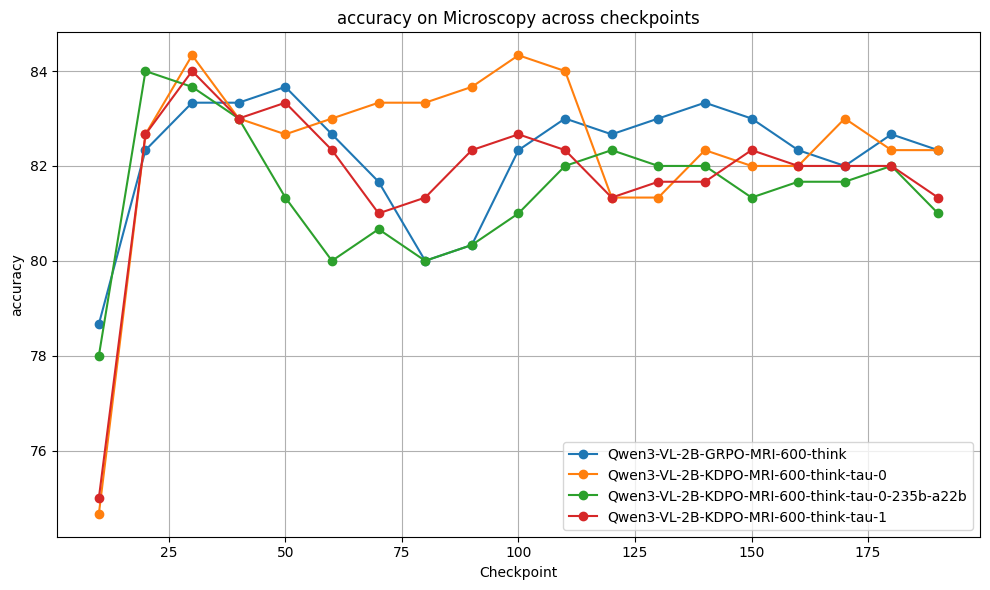

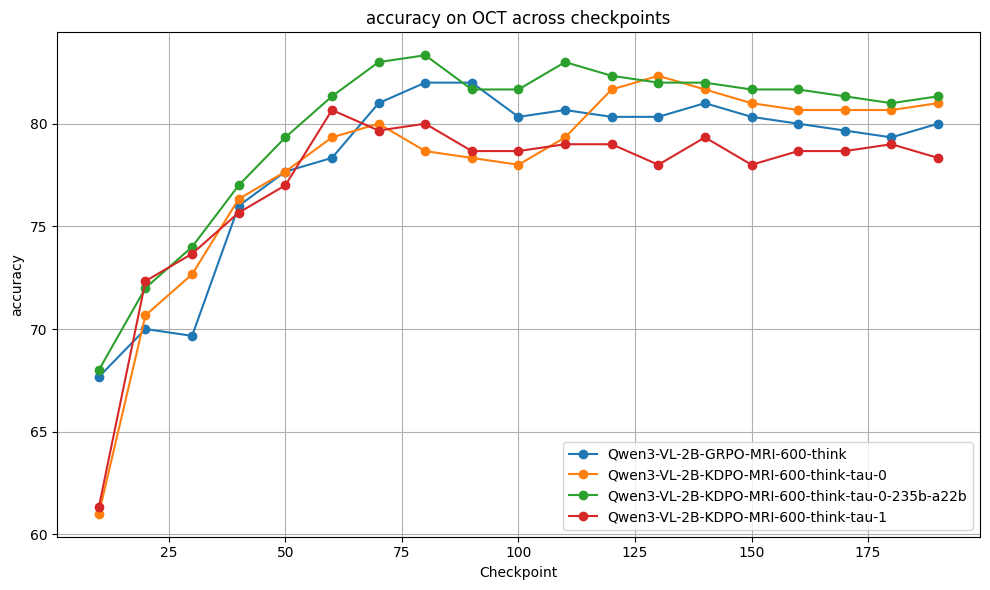

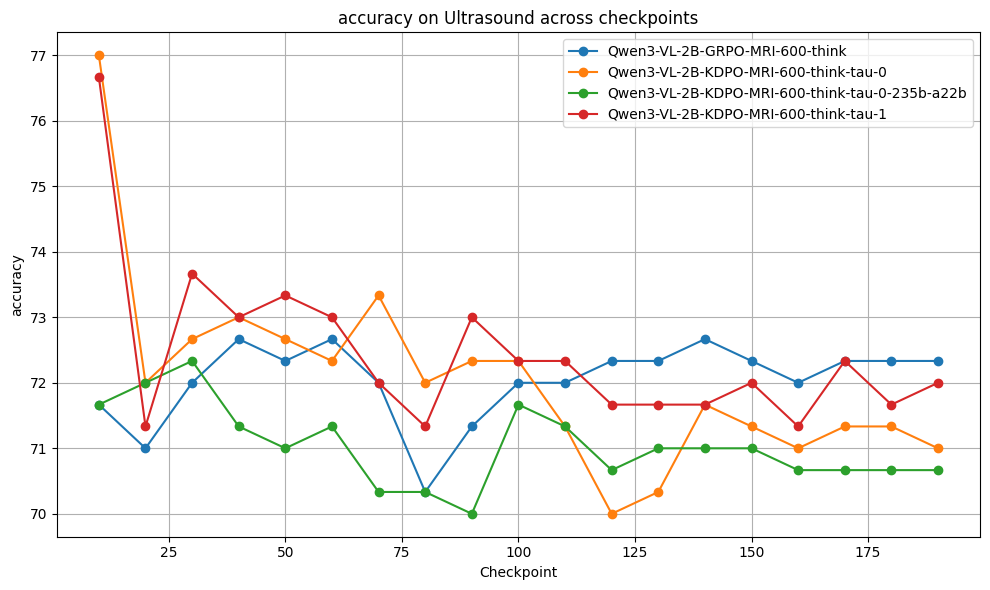

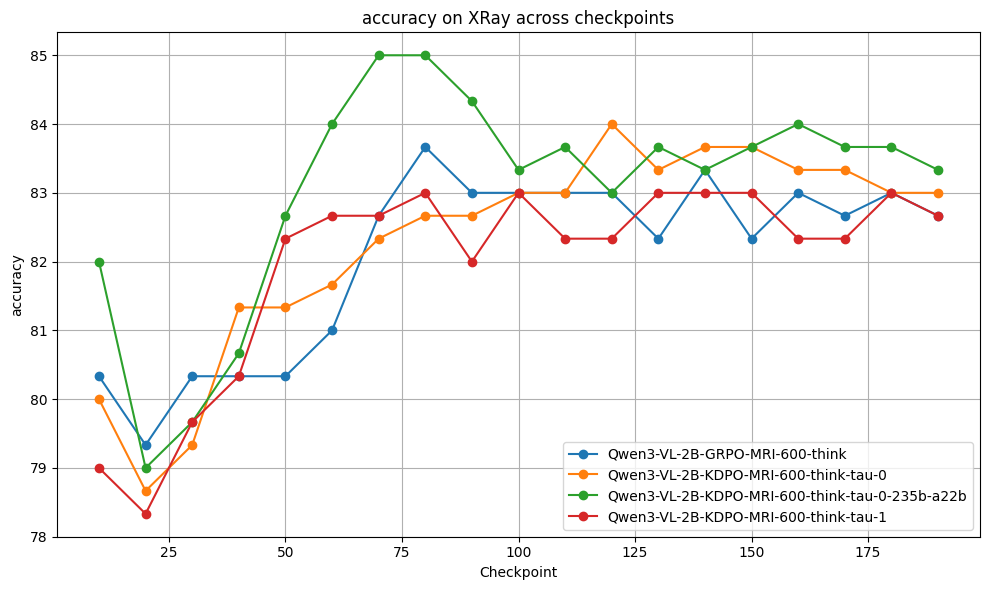

In [6]:
for modality in MODALITIES:
    plot_metric_across_checkpoints(results, modality=modality, metric='accuracy')